# Deadsea seascrolls training

In [13]:
%load_ext autoreload
%autoreload 2
from glob import glob
from torch.utils.data import DataLoader

from monai.networks.nets import UNETR
from monai.data import CacheDataset, Dataset, list_data_collate
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    ScaleIntensityd,
    EnsureTyped,
    RandAffined,
    RandGaussianNoised,
    RandCoarseDropoutd,
    Lambdad,
)
import os
import numpy as np
import matplotlib.pyplot as plt
import wandb 

# ensure is in parent directory
try:
    print(os.getcwd())
    os.chdir("../../rug-hr/")
    print(os.getcwd())
except:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\mo\Documents\Organisations\RUG\rug-hr


### Setting up the experiment

In [37]:
SPATIAL_SIZE = [128, 1024]
SPATIAL_ALIAS = "x".join([str(x) for x in SPATIAL_SIZE])
VERSION = "v1"
ALIAS = "dss"
MODEL_OUTPUT_NAME = f"seglm-{VERSION}-{SPATIAL_ALIAS}-{ALIAS}.pt"

config = {
    "epochs": 200,
    "batch_size": 4,
    "learning_rate": 1e-4,
    "architecture": "UNETR",
    "spatial_size": [256, 256],
    "splits": [0.7, 0.3],
    "model_output_name": MODEL_OUTPUT_NAME,
    "description": "Hebrew UNETR trained on artificial seascrolls dataset",
    "pretrained_model": None,
    "dataset": "dss_corrupted",
    "dataset_benchmark": "dss_benchmark",
}

def init_experiment(config=config):
    wandb.init(
        project="handwriting-recognition-seascrolls",
        config=config,
    )

def terminate_experiment():
    wandb.finish()

def log(data):
    wandb.log(data)

# print summary
print("Configuration:")
print("Output model name: ", config["model_output_name"])
print("Using model: ", config["architecture"])
print("Using dataset: ", config["dataset"])
print("Using benchmark dataset: ", config["dataset_benchmark"])
print("Using spatial size: ", config["spatial_size"])
print("Using splits: ", config["splits"])
print("Using learning rate: ", config["learning_rate"])
print("Using batch size: ", config["batch_size"])
print("Using epochs: ", config["epochs"])
print("Using pretrained model: ", config["pretrained_model"])

Configuration:
Output model name:  seglm-v1-128x1024-dss.pt
Using model:  UNETR
Using dataset:  dss_corrupted
Using benchmark dataset:  dss_benchmark
Using spatial size:  [256, 256]
Using splits:  [0.7, 0.3]
Using learning rate:  0.0001
Using batch size:  4
Using epochs:  200
Using pretrained model:  None


### Setting up the data

In [38]:
# Load paths
splits = config.get("splits", [0.7, 0.3])
training_dataset = config.get("dataset")
benchmark_dataset = config.get("dataset_benchmark")
fraction = 1

print(f"Training on {training_dataset} and benchmarking on {benchmark_dataset} with fraction {fraction}")


train_images = sorted(glob(os.path.join("./datasets", f"{training_dataset}/Raw/*")))
train_segs = sorted(glob(os.path.join("./datasets", f"{training_dataset}/Mutated/*")))
train_images = train_images[:int(len(train_images)*fraction)]
train_segs = train_segs[:int(len(train_segs)*fraction)]

test_images = sorted(glob(os.path.join("./datasets", f"{benchmark_dataset}/Raw/*")))
test_segs = sorted(glob(os.path.join("./datasets", f"{benchmark_dataset}/Mutated/*")))

# Training and validation split
split_i = int(len(train_images)*splits[0])
train_files = [{"img": image_name, "seg": seg_name} for image_name, seg_name in zip(train_images[:split_i], train_segs[:split_i])]
val_files = [{"img": image_name, "seg": seg_name} for image_name, seg_name in zip(train_images[split_i:], train_segs[split_i:])]
test_files = [{"img": image_name, "seg": seg_name} for image_name, seg_name in zip(test_images, test_segs)]

print(f"N_train = {len(train_files)}; N_val = {len(val_files)}; N_test = {len(test_files)}")

Training on dss_corrupted and benchmarking on dss_benchmark with fraction 1
N_train = 5734; N_val = 2458; N_test = 512


#### Transformations
The data is transformed as follows:
- A channel is added
- Randomly intensity scale
- Randomly crop with given spatial size
- Random affine transformation and shearing

In [39]:
# Create transformations
spatial_size = config.get("spatial_size")

augmentation_transforms = [
    RandAffined(
        keys=["img", "seg"],
        shear_range=0.3,
        mode=("bilinear", "nearest"),
        prob=1,
        padding_mode="zeros",
    ),
    RandGaussianNoised(
        keys=["img"],
        prob=1,
        mean=0.0,
        std=0.2
    ),
    RandCoarseDropoutd(
        keys=["img"],
        holes=512,
        spatial_size=(16, 16),
        max_holes=512,
        prob=1,
        fill_value=0,
    ),
    RandCropByPosNegLabeld(
        keys=["img", "seg"],
        label_key="seg",
        spatial_size=spatial_size,
        pos=1,
        neg=1,
        num_samples=4,
        image_key="img",
        image_threshold=0,
    ),
    ScaleIntensityd(keys=["img"]),
]

train_transforms = Compose([
    LoadImaged(keys=["img", "seg"]),
    AddChanneld(keys=["img", "seg"]),
    Lambdad(keys=["img"], func=lambda x: np.where(x > 0, 1, 0)),
    *augmentation_transforms,
    EnsureTyped(keys=["img", "seg"]),
])

val_transforms = Compose([
    LoadImaged(keys=["img", "seg"]),
    AddChanneld(keys=["img", "seg"]),
    Lambdad(keys=["img"], func=lambda x: np.where(x > 0, 1, 0)),
    EnsureTyped(keys=["img", "seg"]),
])

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


torch.Size([256, 256]) tensor(0.) tensor(1.)
torch.Size([256, 256]) tensor(0.) tensor(22.)


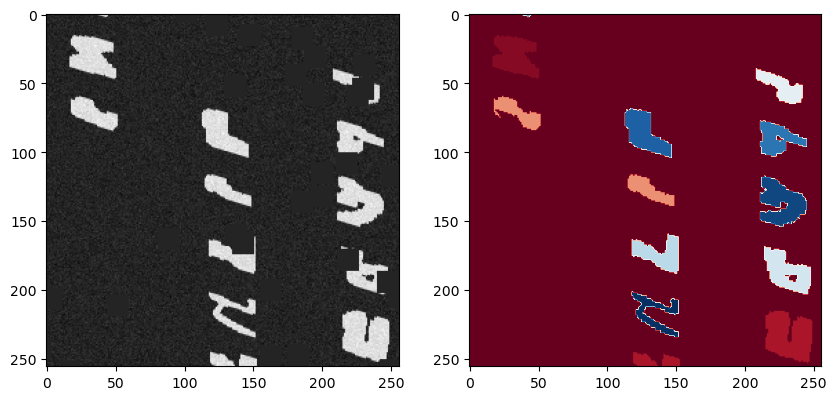

In [41]:
# test train tansform on small sample
choose = np.random.choice(len(train_files))
cropped_sample = train_transforms(train_files[choose])[0]
original = cropped_sample["img"][0, :, :]
label = cropped_sample["seg"][0, :, :]
print(original.shape, original.min(), original.max())
print(label.shape, label.min(), label.max())

# subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original[:, :], cmap="gray")
ax[1].imshow(28-label[:, :], cmap="RdBu_r")
plt.show()

#### Load the dataset

In [32]:
train_loader = DataLoader(
    CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.2),
    shuffle=True,
    batch_size=config.get("batch_size"), 
    num_workers=4, 
    pin_memory=True,
    collate_fn=list_data_collate,
)

val_loader = DataLoader(
    Dataset(data=val_files, transform=val_transforms),
    batch_size=config.get("batch_size"), 
    num_workers=4, 
    pin_memory=True
)

test_loader = DataLoader(
    Dataset(data=test_files, transform=val_transforms),
    batch_size=config.get("batch_size"),
    num_workers=4,
    pin_memory=True
)

Loading dataset: 100%|██████████| 286/286 [00:05<00:00, 55.58it/s]


### Training experiment execution

In [16]:

from modules.segnet import SEGNET
from monai.networks.nets import AttentionUnet
import torch

print("device name", torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_output_name = config.get("model_output_name")

model = UNETR(
    in_channels=1,
    out_channels=28,
    img_size=spatial_size,
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.3,
    spatial_dims=2,
).to(device)

# model = UNet(
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=28,
#     strides=(2, 2, 2, 2),
#     num_res_units=1,
#     dropout=0.4,
# ).to(device)

# model = AttentionUnet(
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=28,
#     channels=(16, 32, 64, 128),
#     strides=(2, 2, 2, 2),
#     dropout=0.4,
# ).to(device)

net = SEGNET(
    model_name=model_output_name,
    device=device, 
    load=False,
    model=model,
    img_size=spatial_size
)

pre_trained_model = config.get("pretrained_model", None)
if pre_trained_model:
    try:
        net.load_model(pre_trained_model)
        print("model loaded")
    except:
        print("could not load model")

# print number of trainable parameters
print("number of trainable parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

device name NVIDIA GeForce RTX 3090
number of trainable parameters 87315836


In [8]:
init_experiment(config)
train_loss, test_loss, metrics = net.train(
    trainloader=train_loader, 
    valloader=val_loader,
    log=log, 
    epochs=config.get("epochs"), 
    learning_rate=config.get("learning_rate"), 
    optimizer_name="adam", 
    schedule=False,
)
terminate_experiment()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: massaf (rug-ai-group). Use `wandb login --relogin` to force relogin


epochs=200; N=1228; batches=307; learning_rate=0.0001


100%|██████████| 103/103 [04:28<00:00,  2.61s/it]


current best metric: 0.005599227733910084


100%|██████████| 103/103 [04:29<00:00,  2.62s/it]


epoch 1/200; train_loss=3.7241336771253652; test_loss=3.2275803991891805; lr=0.0001; metric=0.05267677828669548


100%|██████████| 103/103 [04:32<00:00,  2.64s/it]


epoch 2/200; train_loss=2.9435865009258158; test_loss=2.5684077068439963; lr=0.0001; metric=0.05569226294755936


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 3/200; train_loss=2.3162417178821872; test_loss=1.9934156276647328; lr=0.0001; metric=0.061102211475372314


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 4/200; train_loss=1.865450156239811; test_loss=1.629113341998128; lr=0.0001; metric=0.06073296070098877


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 5/200; train_loss=1.5953461487052496; test_loss=1.4387686426199755; lr=0.0001; metric=0.06317511945962906


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 6/200; train_loss=1.4536885357058398; test_loss=1.3189003872639924; lr=0.0001; metric=0.07643397152423859


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 7/200; train_loss=1.3675843085062231; test_loss=1.2403158204069415; lr=0.0001; metric=0.07817161083221436


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 8/200; train_loss=1.3094716029369093; test_loss=1.192195916638791; lr=0.0001; metric=0.09347926825284958


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 9/200; train_loss=1.2711760314357397; test_loss=1.1597905922861933; lr=0.0001; metric=0.09858500212430954


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 10/200; train_loss=1.248141705019078; test_loss=1.1284195138412771; lr=0.0001; metric=0.12451045215129852


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 11/200; train_loss=1.2216842943371702; test_loss=1.098241753948545; lr=0.0001; metric=0.14164014160633087


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 12/200; train_loss=1.2001582473419388; test_loss=1.0771908308695821; lr=0.0001; metric=0.16173775494098663


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 13/200; train_loss=1.1836279362731337; test_loss=1.0571086406707764; lr=0.0001; metric=0.17636707425117493


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 14/200; train_loss=1.171031039778495; test_loss=1.0381330870887608; lr=0.0001; metric=0.19070307910442352


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 15/200; train_loss=1.1569087043258965; test_loss=1.0187263239934607; lr=0.0001; metric=0.21637335419654846


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 16/200; train_loss=1.1439500480210743; test_loss=1.003927623183982; lr=0.0001; metric=0.2176208645105362


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 17/200; train_loss=1.1308211476484418; test_loss=0.9833887225215875; lr=0.0001; metric=0.2679632902145386


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 18/200; train_loss=1.1175753821767502; test_loss=0.9548181063920549; lr=0.0001; metric=0.2909119725227356


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 19/200; train_loss=1.1040601536194743; test_loss=0.9307816312151048; lr=0.0001; metric=0.2978319823741913


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 20/200; train_loss=1.0899571801629828; test_loss=0.9074320550103789; lr=0.0001; metric=0.30248722434043884


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 21/200; train_loss=1.0780696356335369; test_loss=0.8968614687040014; lr=0.0001; metric=0.3348284363746643


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 22/200; train_loss=1.064917635063395; test_loss=0.8659640110812141; lr=0.0001; metric=0.3801533877849579


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 23/200; train_loss=1.0521245965740191; test_loss=0.8516526499998223; lr=0.0001; metric=0.3997350037097931


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 24/200; train_loss=1.0408189908301015; test_loss=0.8254740267123991; lr=0.0001; metric=0.42980727553367615


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 25/200; train_loss=1.0293666460226725; test_loss=0.8004501641375347; lr=0.0001; metric=0.438807874917984


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 26/200; train_loss=1.019768498231223; test_loss=0.7868520524895307; lr=0.0001; metric=0.44983699917793274


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 27/200; train_loss=1.012440258012144; test_loss=0.7811500557418009; lr=0.0001; metric=0.450695276260376


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 28/200; train_loss=1.0059127980412412; test_loss=0.7580418679320696; lr=0.0001; metric=0.4688049256801605


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 29/200; train_loss=0.9978652526578996; test_loss=0.7470025009321934; lr=0.0001; metric=0.47300779819488525


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 30/200; train_loss=0.9902924186631988; test_loss=0.7286336919636403; lr=0.0001; metric=0.4808633327484131


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 31/200; train_loss=0.9879630112880993; test_loss=0.7280552578203886; lr=0.0001; metric=0.48398545384407043


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 32/200; train_loss=0.9810526662230104; test_loss=0.7157681271867845; lr=0.0001; metric=0.4889635145664215


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 33/200; train_loss=0.9768785603271634; test_loss=0.7122733448315592; lr=0.0001; metric=0.4784996509552002


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 34/200; train_loss=0.9751383590387599; test_loss=0.7010696223638591; lr=0.0001; metric=0.5021825432777405


100%|██████████| 103/103 [04:33<00:00,  2.66s/it]


epoch 35/200; train_loss=0.9713335351757584; test_loss=0.6935392213099211; lr=0.0001; metric=0.5115465521812439


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 36/200; train_loss=0.9695183539623546; test_loss=0.6889623449844064; lr=0.0001; metric=0.5314882397651672


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 37/200; train_loss=0.9633735171746741; test_loss=0.6826851969783746; lr=0.0001; metric=0.5492783188819885


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 38/200; train_loss=0.9608175599225569; test_loss=0.6628944891170391; lr=0.0001; metric=0.5693674683570862


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 39/200; train_loss=0.9573670897499358; test_loss=0.6601829233678799; lr=0.0001; metric=0.5823289155960083


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 40/200; train_loss=0.9553141590050067; test_loss=0.6713107396098017; lr=0.0001; metric=0.5738322734832764


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 41/200; train_loss=0.9517070231686198; test_loss=0.6431613246214043; lr=0.0001; metric=0.6111608147621155


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 42/200; train_loss=0.947620206236451; test_loss=0.6495780366138347; lr=0.0001; metric=0.6044411063194275


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 43/200; train_loss=0.9458198465819467; test_loss=0.634609854915767; lr=0.0001; metric=0.6239306330680847


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 44/200; train_loss=0.9431941150065742; test_loss=0.6169438159581527; lr=0.0001; metric=0.6290949583053589


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 45/200; train_loss=0.9400843717764565; test_loss=0.6312485701829484; lr=0.0001; metric=0.6487303376197815


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 46/200; train_loss=0.9379157635598695; test_loss=0.617876099151315; lr=0.0001; metric=0.6576828956604004


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 47/200; train_loss=0.9337608090052776; test_loss=0.5993923272901368; lr=0.0001; metric=0.6625241041183472


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 48/200; train_loss=0.9299461439688742; test_loss=0.5988086768724386; lr=0.0001; metric=0.6841437220573425


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 49/200; train_loss=0.9263132313563691; test_loss=0.5803973917822236; lr=0.0001; metric=0.6960524916648865


100%|██████████| 103/103 [04:32<00:00,  2.65s/it]


epoch 50/200; train_loss=0.9253068719702358; test_loss=0.5777269231462941; lr=0.0001; metric=0.6890178322792053


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 51/200; train_loss=0.9221877246027272; test_loss=0.5559650098235862; lr=0.0001; metric=0.7132377028465271


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 52/200; train_loss=0.9196322137059141; test_loss=0.5526775330015756; lr=0.0001; metric=0.7235587239265442


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 53/200; train_loss=0.9184969572368584; test_loss=0.5675062676077908; lr=0.0001; metric=0.7093840837478638


100%|██████████| 103/103 [04:33<00:00,  2.66s/it]


epoch 54/200; train_loss=0.9183292817991797; test_loss=0.5471655978161154; lr=0.0001; metric=0.7283914685249329


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 55/200; train_loss=0.9143931015306653; test_loss=0.5314922057887883; lr=0.0001; metric=0.7362030744552612


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 56/200; train_loss=0.9126727848953844; test_loss=0.5245658882613321; lr=0.0001; metric=0.7467818260192871


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 57/200; train_loss=0.9121958153255599; test_loss=0.5016423709762906; lr=0.0001; metric=0.7713979482650757


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 58/200; train_loss=0.9100332456225293; test_loss=0.522893912005193; lr=0.0001; metric=0.7527729272842407


100%|██████████| 103/103 [04:31<00:00,  2.63s/it]


epoch 59/200; train_loss=0.908596836782822; test_loss=0.5357760219898039; lr=0.0001; metric=0.741491973400116


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 60/200; train_loss=0.9083310620015917; test_loss=0.520944793826168; lr=0.0001; metric=0.7630323171615601


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 61/200; train_loss=0.90547428981489; test_loss=0.5242819103222449; lr=0.0001; metric=0.7590069770812988


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 62/200; train_loss=0.9032176059309746; test_loss=0.5209532845946192; lr=0.0001; metric=0.7546409964561462


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 63/200; train_loss=0.9025260580867431; test_loss=0.5154201961258082; lr=0.0001; metric=0.7738353610038757


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 64/200; train_loss=0.90124981119889; test_loss=0.5012850159580268; lr=0.0001; metric=0.7767167091369629


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 65/200; train_loss=0.9012436888116967; test_loss=0.50468222406304; lr=0.0001; metric=0.7791897654533386


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 66/200; train_loss=0.8985485850017312; test_loss=0.4937487030492246; lr=0.0001; metric=0.7817690968513489


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 67/200; train_loss=0.8996894153787569; test_loss=0.4968124694615892; lr=0.0001; metric=0.7835103273391724


100%|██████████| 103/103 [04:31<00:00,  2.63s/it]


epoch 68/200; train_loss=0.898870971575622; test_loss=0.5090470481844782; lr=0.0001; metric=0.7814105749130249


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 69/200; train_loss=0.8961203806951691; test_loss=0.49404198857187065; lr=0.0001; metric=0.7889280915260315


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 70/200; train_loss=0.8971818438958655; test_loss=0.500785610050831; lr=0.0001; metric=0.7786970734596252


100%|██████████| 103/103 [04:31<00:00,  2.63s/it]


epoch 71/200; train_loss=0.8949234689485754; test_loss=0.4855030213744895; lr=0.0001; metric=0.8056015372276306


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 72/200; train_loss=0.8950743855793235; test_loss=0.4910789438821737; lr=0.0001; metric=0.7970739603042603


100%|██████████| 103/103 [04:34<00:00,  2.66s/it]


epoch 73/200; train_loss=0.8925482597723846; test_loss=0.491733873932107; lr=0.0001; metric=0.7958869934082031


100%|██████████| 103/103 [04:33<00:00,  2.66s/it]


epoch 74/200; train_loss=0.8923135112473554; test_loss=0.48555337167480617; lr=0.0001; metric=0.804767906665802


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 75/200; train_loss=0.89076616903858; test_loss=0.47160916421019916; lr=0.0001; metric=0.8024019598960876


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 76/200; train_loss=0.8895633049818903; test_loss=0.4799868267716713; lr=0.0001; metric=0.8043856024742126


100%|██████████| 103/103 [04:33<00:00,  2.66s/it]


epoch 77/200; train_loss=0.8886070055371387; test_loss=0.48658228904298206; lr=0.0001; metric=0.7995491027832031


100%|██████████| 103/103 [04:31<00:00,  2.63s/it]


epoch 78/200; train_loss=0.8898428105764358; test_loss=0.4637790038747695; lr=0.0001; metric=0.8146412968635559


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 79/200; train_loss=0.889429035132405; test_loss=0.45097324367865776; lr=0.0001; metric=0.8287439942359924


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 80/200; train_loss=0.8869322969393155; test_loss=0.4385717302850149; lr=0.0001; metric=0.8389749526977539


100%|██████████| 103/103 [04:31<00:00,  2.64s/it]


epoch 81/200; train_loss=0.8865118690733024; test_loss=0.45193394526694586; lr=0.0001; metric=0.8179894685745239


100%|██████████| 103/103 [04:33<00:00,  2.65s/it]


epoch 82/200; train_loss=0.88510040390375; test_loss=0.4526237541610755; lr=0.0001; metric=0.8189868330955505


100%|██████████| 103/103 [04:32<00:00,  2.64s/it]


epoch 83/200; train_loss=0.8851075620915292; test_loss=0.4543296460387776; lr=0.0001; metric=0.8164005875587463


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 84/200; train_loss=0.885556511653751; test_loss=0.4639888093309495; lr=0.0001; metric=0.8157549500465393


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 85/200; train_loss=0.8832343385739901; test_loss=0.450860159489715; lr=0.0001; metric=0.8271832466125488


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 86/200; train_loss=0.8846836992894399; test_loss=0.4653541277913214; lr=0.0001; metric=0.8142086863517761


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 87/200; train_loss=0.8825490952314694; test_loss=0.46395337263357295; lr=0.0001; metric=0.8152185678482056


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 88/200; train_loss=0.8805950184986724; test_loss=0.4395709659868074; lr=0.0001; metric=0.8310237526893616


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 89/200; train_loss=0.8808112321148478; test_loss=0.4504032395418408; lr=0.0001; metric=0.8253660798072815


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 90/200; train_loss=0.8827027657132972; test_loss=0.4681646149714016; lr=0.0001; metric=0.8109979629516602


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 91/200; train_loss=0.8818417583692346; test_loss=0.4605062331968141; lr=0.0001; metric=0.81715327501297


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 92/200; train_loss=0.8800978973168115; test_loss=0.43227945890241454; lr=0.0001; metric=0.8329249024391174


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 93/200; train_loss=0.8785214309583658; test_loss=0.4536244359988611; lr=0.0001; metric=0.824881374835968


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 94/200; train_loss=0.8801634047629391; test_loss=0.41638848764225117; lr=0.0001; metric=0.8520061373710632


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 95/200; train_loss=0.8771448609106703; test_loss=0.43116104139865025; lr=0.0001; metric=0.842779815196991


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 96/200; train_loss=0.8778105884887496; test_loss=0.45279112053148957; lr=0.0001; metric=0.8228207230567932


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 97/200; train_loss=0.8783422850242267; test_loss=0.4578826612639196; lr=0.0001; metric=0.8246666193008423


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 98/200; train_loss=0.8775370260791592; test_loss=0.4468536246748804; lr=0.0001; metric=0.8288463950157166


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 99/200; train_loss=0.87691908841801; test_loss=0.4294385235865139; lr=0.0001; metric=0.8402138352394104


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 100/200; train_loss=0.874755214790568; test_loss=0.48904322970260694; lr=0.0001; metric=0.8062393069267273


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 101/200; train_loss=0.8763236708283813; test_loss=0.4284317672831341; lr=0.0001; metric=0.8436614871025085


100%|██████████| 103/103 [04:28<00:00,  2.60s/it]


epoch 102/200; train_loss=0.8749087685870813; test_loss=0.4597120805851464; lr=0.0001; metric=0.8192294836044312


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 103/200; train_loss=0.875892153197857; test_loss=0.43521327359005085; lr=0.0001; metric=0.8325029611587524


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 104/200; train_loss=0.8752649038156392; test_loss=0.41836067108274666; lr=0.0001; metric=0.8394820094108582


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 105/200; train_loss=0.8734217163794203; test_loss=0.4166181729835214; lr=0.0001; metric=0.8534207344055176


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 106/200; train_loss=0.8750326656751601; test_loss=0.4558795163932356; lr=0.0001; metric=0.8187246322631836


100%|██████████| 103/103 [04:33<00:00,  2.66s/it]


epoch 107/200; train_loss=0.8723024314311895; test_loss=0.4353192086937358; lr=0.0001; metric=0.8375400900840759


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 108/200; train_loss=0.8723934463646978; test_loss=0.445654507979606; lr=0.0001; metric=0.829364538192749


100%|██████████| 103/103 [04:26<00:00,  2.59s/it]


epoch 109/200; train_loss=0.8720195299251072; test_loss=0.430336635089615; lr=0.0001; metric=0.8400427103042603


100%|██████████| 103/103 [04:27<00:00,  2.59s/it]


epoch 110/200; train_loss=0.8698255677953217; test_loss=0.4040686366627517; lr=0.0001; metric=0.8517202734947205


100%|██████████| 103/103 [04:28<00:00,  2.60s/it]


epoch 111/200; train_loss=0.8714095952068167; test_loss=0.41658868430887613; lr=0.0001; metric=0.846201479434967


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 112/200; train_loss=0.8704052183061158; test_loss=0.40622934293978424; lr=0.0001; metric=0.860034167766571


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 113/200; train_loss=0.8695009632296982; test_loss=0.41389976369524467; lr=0.0001; metric=0.8509810566902161


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 114/200; train_loss=0.8700374291075169; test_loss=0.4326504549933869; lr=0.0001; metric=0.8339657783508301


100%|██████████| 103/103 [04:28<00:00,  2.60s/it]


epoch 115/200; train_loss=0.8706063700032933; test_loss=0.4386209226349025; lr=0.0001; metric=0.8364341855049133


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 116/200; train_loss=0.8692041536495818; test_loss=0.41099602823118564; lr=0.0001; metric=0.8503499627113342


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 117/200; train_loss=0.8693376956234538; test_loss=0.40015259848057644; lr=0.0001; metric=0.8585917949676514


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 118/200; train_loss=0.8680921785217931; test_loss=0.4575748397308646; lr=0.0001; metric=0.8184857368469238


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 119/200; train_loss=0.8701563749328887; test_loss=0.41006532456110983; lr=0.0001; metric=0.8469898700714111


100%|██████████| 103/103 [04:29<00:00,  2.62s/it]


epoch 120/200; train_loss=0.8680234862072849; test_loss=0.41816827539101387; lr=0.0001; metric=0.8460342288017273


100%|██████████| 103/103 [04:28<00:00,  2.60s/it]


epoch 121/200; train_loss=0.868758400410705; test_loss=0.41880243090749947; lr=0.0001; metric=0.8396061658859253


100%|██████████| 103/103 [04:27<00:00,  2.59s/it]


epoch 122/200; train_loss=0.8680492911354338; test_loss=0.3942617623551378; lr=0.0001; metric=0.865013599395752


100%|██████████| 103/103 [04:27<00:00,  2.59s/it]


epoch 123/200; train_loss=0.8660691755214033; test_loss=0.41680397397106134; lr=0.0001; metric=0.8486989140510559


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 124/200; train_loss=0.8672757241935606; test_loss=0.4101918475720489; lr=0.0001; metric=0.8498650789260864


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 125/200; train_loss=0.8669066229161688; test_loss=0.40119038218433417; lr=0.0001; metric=0.8610771298408508


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 126/200; train_loss=0.8669062196625948; test_loss=0.41440909493316724; lr=0.0001; metric=0.8435881733894348


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 127/200; train_loss=0.8657484613723009; test_loss=0.41921644042996525; lr=0.0001; metric=0.8485432863235474


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 128/200; train_loss=0.8659327833970906; test_loss=0.41389342390217826; lr=0.0001; metric=0.8495674133300781


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 129/200; train_loss=0.8664603470202766; test_loss=0.4022380770410149; lr=0.0001; metric=0.8623259663581848


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 130/200; train_loss=0.8653972030462582; test_loss=0.40183855057920065; lr=0.0001; metric=0.8598694801330566


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 131/200; train_loss=0.8644384415607888; test_loss=0.459679694430342; lr=0.0001; metric=0.8149999976158142


100%|██████████| 103/103 [04:27<00:00,  2.59s/it]


epoch 132/200; train_loss=0.8642671378117043; test_loss=0.4076296690019589; lr=0.0001; metric=0.8542513847351074


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 133/200; train_loss=0.8638518598258301; test_loss=0.4348455994453245; lr=0.0001; metric=0.8331609964370728


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 134/200; train_loss=0.8633681254200516; test_loss=0.3990931597728174; lr=0.0001; metric=0.8604239821434021


100%|██████████| 103/103 [04:28<00:00,  2.60s/it]


epoch 135/200; train_loss=0.8634499781294832; test_loss=0.39082233564367574; lr=0.0001; metric=0.863657534122467


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 136/200; train_loss=0.8634294914112028; test_loss=0.41725733760491157; lr=0.0001; metric=0.8469284176826477


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 137/200; train_loss=0.8638434353791153; test_loss=0.4151209358451436; lr=0.0001; metric=0.8500690460205078


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 138/200; train_loss=0.8632098424706475; test_loss=0.3833403839069663; lr=0.0001; metric=0.8757139444351196


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 139/200; train_loss=0.862727090861976; test_loss=0.41648830690430205; lr=0.0001; metric=0.8537235856056213


100%|██████████| 103/103 [04:28<00:00,  2.60s/it]


epoch 140/200; train_loss=0.8611033275383692; test_loss=0.4026664197444916; lr=0.0001; metric=0.8598476052284241


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 141/200; train_loss=0.8612807783319429; test_loss=0.38956008692389554; lr=0.0001; metric=0.8748940825462341


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 142/200; train_loss=0.8615221342357051; test_loss=0.39636633291985224; lr=0.0001; metric=0.8675252795219421


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 143/200; train_loss=0.8624482391711555; test_loss=0.4029390056735104; lr=0.0001; metric=0.8574955463409424


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 144/200; train_loss=0.8613126635163149; test_loss=0.4083781551967547; lr=0.0001; metric=0.8502103686332703


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 145/200; train_loss=0.8620501193627472; test_loss=0.41327546985404007; lr=0.0001; metric=0.8552467823028564


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 146/200; train_loss=0.8610793317179727; test_loss=0.39364215847357964; lr=0.0001; metric=0.8694345355033875


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 147/200; train_loss=0.8607336834121605; test_loss=0.4140340787114449; lr=0.0001; metric=0.8562206625938416


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 148/200; train_loss=0.8605588313422684; test_loss=0.4022680249028993; lr=0.0001; metric=0.8682041764259338


100%|██████████| 103/103 [04:27<00:00,  2.59s/it]


epoch 149/200; train_loss=0.8601396736182296; test_loss=0.378669127098565; lr=0.0001; metric=0.8781507611274719


100%|██████████| 103/103 [04:27<00:00,  2.60s/it]


epoch 150/200; train_loss=0.8607697884888913; test_loss=0.39999369886314984; lr=0.0001; metric=0.8641321659088135


100%|██████████| 103/103 [04:27<00:00,  2.59s/it]


epoch 151/200; train_loss=0.8591557236370124; test_loss=0.39130640377118747; lr=0.0001; metric=0.8642711639404297


 59%|█████▉    | 61/103 [02:42<01:51,  2.66s/it]


KeyboardInterrupt: 

In [17]:
# load the best model
net.load_model(f"./models/{model_output_name}");

(1512, 1024)


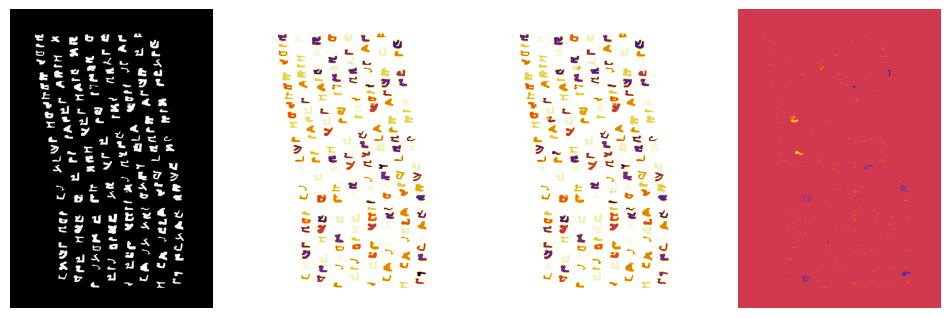

In [28]:
choice = np.random.choice(len(test_files))
sample = val_transforms(test_files[choice])
x, y = sample["img"], sample["seg"]
x.shape

# Predict
with torch.no_grad():
    yhat = x.cuda()
    yhat = torch.unsqueeze(yhat, 0)
    yhat = net.infere(yhat)
    yhat = torch.squeeze(yhat, 0)
    yhat = torch.argmax(yhat, dim=0)
    yhat = yhat.cpu().numpy()
    
    print(yhat.shape)

diff = yhat - y.cpu().numpy().squeeze(0)

# Plot original, ground truth and prediction
fig, axes = plt.subplots(1, 4, figsize=(12, 8))
axes[0].imshow(x[0, :, :], cmap="gray")
axes[0].axis("off")
axes[1].imshow(28 - y[0, :, :], cmap="CMRmap")
axes[1].axis("off")
axes[2].imshow(28 - yhat, cmap="CMRmap")
axes[2].axis("off")
axes[3].imshow(diff, cmap="CMRmap")
axes[3].axis("off")
plt.show()


In [33]:
net.validate(test_loader)

100%|██████████| 256/256 [11:01<00:00,  2.58s/it]


(0.3579922268399969, 0.8949974775314331)